In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib inline

import math
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)/np.sum(np.array(G))


In [2]:
def get_im2col_indices_blur(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    _, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def blur(im,sigma,k,h,w,stride=1,C=3):
    H,W = im.shape
    g = GaussianFilter(h,w,k*sigma).flatten()
    #g = np.tile(g,C)
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)
    
    k,i,j = get_im2col_indices_blur((1,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)
    
    im_padded = np.pad(im,((h_pad,h_pad),(w_pad,w_pad)),'mean')
    cols = im_padded[i,j]

    return cols.T.dot(g).reshape(H,W)

In [3]:
def grad(direct):
    if direct=='x':
        g = np.array([[0,0,0],[-1,0,1],[0,0,0]])
    if direct=='y':
        g = np.array([[0,-1,0],[0,0,0],[0,1,0]])
    if direct =='mod':
        g = np.array([[0,-1,0],[-1,0,1],[0,1,0]])
    if direct =='xy':
        gx = np.array([[0,0,0],[-1,0,1],[0,0,0]])
        gy = np.array([[0,-1,0],[0,0,0],[0,1,0]])
        g = (gx,gy)
        
    return g
        

In [4]:
def conv2d(im,gauss=False,type_='mod',stride=1,**kwargs):
    h=3
    w=3
    H,W = im.shape
    
    if gauss==True:
        sigma = kwargs['sigma']
        h_g,w_g = kwargs['g']
        
        im = blur(im,sigma,1,h_g,w_g,stride=1,C=3)

    gs = grad(type_)
    sol = []
    for g in gs:
        stride=1

        h_pad = int((H*(stride-1)-stride+h)/2)
        w_pad = int((W*(stride-1)-stride+w)/2)

        k,i,j = get_im2col_indices_blur((1,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)

        im_padded = np.pad(im,((h_pad,h_pad),(w_pad,w_pad)),'constant')
        cols = im_padded[i,j]

        sol.append(cols.T.dot(g.flatten()).reshape(H,W))
    return sol

In [5]:
def Reduce(im,k):   
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im

In [6]:
def Expand(im,k):       
    for j in range(k):
        H,W = im.shape
        Ex = np.zeros((2*H-H%2,H))
        Ex[np.arange(0,2*H-H%2,2,dtype=int),np.arange(H,dtype=int)]=1

        Ey = np.zeros(((2*W-W%2),W))
        Ey[np.arange(0,2*W-W%2,2,dtype=int),np.arange(W)]=1
        im = (Ex.dot(im)).dot(Ey.T)       
    return im

In [7]:
def octave(im,RE,sigma=1.6,s=4):
    #beg = time.time()
    sigma *=RE
    im = Reduce(im,RE)
    k = 2**(1/s)
    G4 = blur(im,sigma,k**4,h=11,w=11)
    G3 = blur(im,sigma,k**3,h=11,w=11)
    G2 = blur(im,sigma,k**2,h=11,w=11)
    G1 = blur(im,sigma,k**1,h=11,w=11)
    G0 = blur(im,sigma,k**0,h=11,w=11)
    
    
    L4= Expand(G4 - G3,RE)
    L3= Expand(G3 - G2,RE)
    L2= Expand(G2-G1,RE)
    L1= Expand(G1 - G0,RE)
    #end = time.time()
    #print('Octave execution time: {}'.format(end-beg))
    return np.stack((L1,L2,L3,L4)),[np.stack((L1,L2,L3)),np.stack((L2,L3,L4))],[sigma*k**1,sigma*k**2]

In [8]:
def conv2d_max(f,g,k=1,**kwargs):
    C,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_blur((1,3,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[k,i,j]
    
    xc = int((h*w-1)/2) 
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),0)
    
    cond = ((f[1,:,:].flatten() > 
             np.max(cols,axis=0))|(f[1,:,:].flatten() < 
                                   np.min(cols,axis=0)))&(np.abs(f[1,:,:].flatten())>0.03)

    return cond.reshape(H,W).T



In [9]:
def get_deriv(pyr,kp):
    z = kp[2,:].astype(int)
    y = kp[0,:].astype(int)+1
    x = kp[1,:].astype(int)+1

    pyr = np.pad(pyr,((0,0),(1,1),(1,1)),'maximum')


    Ix = pyr[z,x+1,y] - pyr[z,x-1,y]
    Iy = pyr[z,x,y+1] - pyr[z,x,y-1]
    Is = pyr[z+1,x,y] - pyr[z-1,x,y]
    Ixy = pyr[z,x+1,y+1] - pyr[z,x-1,y-1]
    
    #H = np.array([[Ix,Ixy],[Ixy,Iy]])

    Ixx = pyr[z,x+1,y] - 2*pyr[z,x,y] + pyr[z,x-1,y]
    Iyy = pyr[z,x,y+1] - 2*pyr[z,x,y] + pyr[z,x,y-1]
    Iss = pyr[z+1,x,y] - 2*pyr[z,x,y] + pyr[z-1,x,y]
    Ixxyy = pyr[z,x+1,y+1] - 2*pyr[z,x,y] + pyr[z,x-1,y-1]
    Ixxss = pyr[z+1,x+1,y] - 2*pyr[z,x,y] + pyr[z-1,x-1,y]
    Iyyss = pyr[z+1,x,y+1] - 2*pyr[z,x,y] + pyr[z-1,x,y-1]
    
    H = np.array([[Ixx,Ixxyy,Ixxss],[Ixxyy,Iyy,Iyyss],[Ixxss,Iyyss,Iss]])
    J = np.array([[Ix**2,Ix*Iy],[Ix*Iy,Iy**2]])
    dx = np.array([Ix,Iy,Is])
    return H,dx,J

In [10]:
def refine_location_prune(im,pyr,kp):
    #pyr = pyramid[0]
    H,dx,J = get_deriv(pyr,kp)

    U,S,V = np.linalg.svd(np.moveaxis(H,2,0))
    S = S[:,:,np.newaxis]*np.diag(np.ones(3))
    A = np.linalg.inv(S)
    H_inv = np.matmul(np.matmul(A,S),V)
    deltas = np.squeeze(np.matmul(H_inv,np.moveaxis(dx,1,0)[:,:,np.newaxis]))
    

    if kp.shape[1]!=0:
        keep = harris(im,kp)
        return (deltas,keep)
    else:
        return (deltas,None)
    #return (deltas,None)
    
    

In [11]:
def get_patch(im,kp,h=9,w=9):
    h_ = int((h-1)/2)
    w_ = int((w-1)/2)
    im = np.pad(im,((h_,h_),(w_,w_)),'mean')
    mypks=kp[:2].astype(int).T
    patches=[]
    for i in mypks:
        p = im[i[1]:i[1]+h,i[0]:i[0]+w]
        patches.append(p)
        if p.shape[0]==0:
            print(i)
    
    return np.dstack(patches)

In [12]:
def harris(im,kp):
    Ix,Iy = conv2d(im,gauss=False,type_='xy',stride=1)
    Ixs = np.sum(get_patch(Ix,kp,h=3,w=3),axis=(0,1))
    Iys = np.sum(get_patch(Iy,kp,h=3,w=3),axis=(0,1))
    H = np.array([[Ixs**2,Ixs*Iys],[Ixs*Iys,Iys**2]])
    tr = np.trace(H)**2
    det = np.linalg.det(np.moveaxis(H,2,0))
    corners = np.divide(tr,det,out=np.zeros_like(tr),where=det!=0)>0.03
    return corners
    

In [13]:
def HOG(im,kp):
    Ix,Iy = conv2d(im,gauss=False,type_='xy',stride=1,**{'sigma':1,'g':(3,3)})
    Ixs = get_patch(Ix,kp,h=17,w=17)
    Iys = get_patch(Iy,kp,h=17,w=17)
    Imag = np.sqrt(Ixs**2+Iys**2)
    orient = np.abs(np.arctan2(Iys,Ixs))

    bins = np.arange(0,170,10)*math.pi/180

    hist=[]
    for k in range(Imag.shape[2]):
        P = orient[:,:,k]
        D = Imag[:,:,k]


        O = np.argmin((P[:,:,np.newaxis]-bins)**2,axis=2).astype(int)

        count = np.zeros_like(bins)

        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                count[O[i,j]]+=D[i,j]

        hist.append(np.argmax(count))
    hist =np.hstack(hist)
    
    return np.array([bins[i] for i in hist])*180/math.pi

In [14]:
def SIFT(im,N=4,std=1.6,s=4,display=False):
 
    kp = []
    sig=[]
    pyramid = {}

    for n in range(N):
        octa,stacks,sigma = octave(im/255,n+1,sigma=std,s=s)

        count = 1
        for i,stack in enumerate(stacks):   

            xk = np.argwhere(conv2d_max(stack,(3,3)))

            if display==True: print('Total of {} kps for a scale equal to  {}'.format(xk.shape[0],sigma[i]))
            sig.append(np.ones(xk.shape[0])*sigma[i])

            xk = np.vstack((xk.T,np.ones(xk.shape[0])*count))
            kp.append(xk)
            count+=1

        deltas,keep = refine_location_prune(im,octa,xk)
        pyramid[n]= octa,xk[:,keep]
        if display==True: print('Remaining kps after prunning: {}'.format(np.sum(keep)))
    kp = np.hstack(kp)
    rho = HOG(im,kp)
    sig = np.hstack(sig)
    xk = np.vstack((kp,sig,rho))
    return xk,deltas


In [15]:
def get_patch2(im,kp,h=9,w=9):
    
    h_ = int((h-1)/2)+1
    w_ = int((w-1)/2)+1
    im = np.pad(im,((h_,h_),(w_,w_)),'mean')
    mypks=kp[:2].astype(int).T
    patches=[]
    count=0
    for i in mypks:
        p = im[i[1]:i[1]+h,i[0]:i[0]+w]

        g = GaussianFilter(h,w,kp[3,count])
        
        patches.append(p*g)
        count+=1
        if p.shape[0]==0:
            print(i)
    return np.dstack(patches)

In [16]:
def split_tensor(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)

    k = A.shape[2]

    z = (np.repeat(np.zeros((64,4)),k).reshape((64,4,-1)) + np.arange(k)).astype(int)
    x = np.repeat(x[:,:,np.newaxis],k,axis=2) 
    y= np.repeat(y[:,:,np.newaxis],k,axis=2)


    return np.dstack(np.split(A[x,y,z],16)).reshape((4,4,16,-1))



In [17]:
def split_matrix(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)
    return np.dstack(np.split(A[x,y],16))

In [18]:
def features(patches,xk):
    Imag = []
    Irho = []
    for i in range(patches.shape[-1]):
        Ix,Iy = conv2d(patches[:,:,i],gauss=False,type_='xy',stride=1)
        Imag.append(np.sqrt(Ix**2+Iy**2))
        Irho.append(np.arctan2(Iy,Ix))
    Imag = split_tensor(np.moveaxis(np.stack(Imag),0,2))
    Irho = split_tensor(np.moveaxis(np.stack(Irho),0,2))
    Irho[Irho<0] = Irho[Irho<0] + 2*math.pi
    Irho *= 180/math.pi
    Irho -= xk[4,:]
    Irho[Irho<0]+=360
    
    bins = np.arange(0,360,45)##hist =np.hstack(hist)*math.pi/180

    fks=[]
    for k in range(Imag.shape[-1]):
        contrib = np.zeros_like(bin)
        W = GaussianFilter(16,16,xk[3,i])
        W = split_matrix(W)
        count = np.zeros_like(bins)
        fk=[]
        for p in range(Imag.shape[-2]):
            P = Irho[:,:,p,k]
            D = Imag[:,:,p,k]#*W[:,:,p]

            O = np.argmin((P[:,:,np.newaxis]-bins)**2,axis=2).astype(int)


            for i in range(P.shape[0]):
                for j in range(P.shape[1]):
                    count[O[i,j]]+=D[i,j]

            fk.append(count)

        fk = np.hstack(fk)
        fks.append(fk)
    return np.stack(fks)

Total of 9 kps for a scale equal to  0.7135242690016326
Total of 0 kps for a scale equal to  0.8485281374238569
Remaining kps after prunning: None
Total of 241 kps for a scale equal to  1.4270485380032651
Total of 246 kps for a scale equal to  1.6970562748477138
Remaining kps after prunning: 125


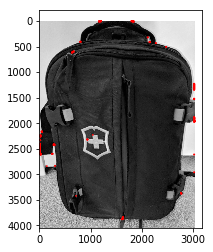

In [54]:
im = plt.imread("img/template.jpg")
im = np.mean(im,axis=2)

xk,deltas = SIFT(im,N=2,std=0.6,display=True)

plt.imshow(im,**{'cmap':'gray'})

plt.scatter(xk[0,:],xk[1,:],color='red',s=xk[4,:]/xk[4,:].max())
plt.show()

patches = get_patch2(im,xk,h=16,w=16)

fk = features(patches,xk)


Total of 135 kps for a scale equal to  0.7135242690016326
Total of 106 kps for a scale equal to  0.8485281374238569
Remaining kps after prunning: 57
Total of 690 kps for a scale equal to  1.4270485380032651
Total of 566 kps for a scale equal to  1.6970562748477138
Remaining kps after prunning: 269


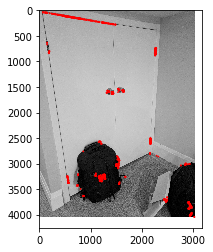

In [55]:
im = plt.imread("img/find.jpg")
im = np.mean(im,axis=2)

xk2,deltas = SIFT(im,N=2,std=0.6,display=True)

plt.imshow(im,**{'cmap':'gray'})

plt.scatter(xk2[0,:],xk2[1,:],color='red',s=xk[4,:]/xk2[4,:].max())
plt.show()

patches = get_patch2(im,xk2,h=16,w=16)

fk2 = features(patches,xk2)

In [62]:
idx = []
for i in range(fk.shape[0]):
    v = fk[i]
    d = np.sum((fk2-v)**2,axis=1)
    f1,f2 = np.argsort(d)[:2]
    phi = np.sum((v - fk2[f1])**2)/np.sum((v - fk2[f2])**2)
    if phi < 0.4:
        idx.append(f1)
    
    
    
    

/home/alien/miniconda3/envs/opencvpy35/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


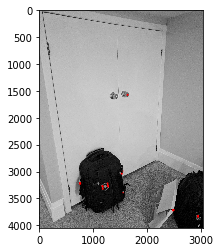

In [63]:
plt.imshow(im,**{'cmap':'gray'})

plt.scatter(xk2[0,idx],xk2[1,idx],color='red',s=xk2[4,idx]/xk2[4,idx].max())
plt.show()

In [43]:
xk2.shape

(5, 7472)

In [25]:
d = np.sum((fk2-fk[1])**2,axis=1)

In [26]:
np.argmin(d)

5356

# Depricated code

In [ ]:
def conv2d_max(f,g,k=1,**kwargs):
    beg = time.time()
    w,h = g
    
    w = int(w)
    h = int(h)
    _,W,H = f.shape

    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))

    f_pad = np.pad(f,((0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='constant')

    I=[]
    for m in range(int(f_pad.shape[2]-w)+1):        
        for n in range(int(f_pad.shape[1]-h+1)):
            
            w = f_pad[:,n:n+3,m:m+3]
           
           
            w_max = w[1,1,1]
            w[1,1,1]=0
            
            if (np.max(w)< w_max)|(np.min(w)>w_max)==True:
                I.append(1)
            else:
                I.append(0)
    end = time.time()
    print('Non-max sup execution time: {}'.format(end-beg))
    return np.array(I).reshape(H,W)


def conv2d_loop(f,g,k=1,**kwargs):
    w,h = g.shape
    W,H = f.shape

    g = np.rot90(g,2)
    

    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))

    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad)),mode='constant')

    I=[]
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            fg = np.multiply(f_pad[m:m+w,n:n+h],g)
            sum_fg = np.sum(fg,axis=(0,1))
            I.append(sum_fg)

    return np.array(I).reshape(W,H)

def blur(im,sigma,k,h=5,w=5,stride=1):
    g = GaussianFilter(h,w,k*sigma)
    return conv2d_loop(im,g,stride)

In [ ]:
bins = np.arange(0,360,45)##hist =np.hstack(hist)*math.pi/180

hist=[]
for k in range(Imag.shape[-1]):
    contrib = np.zeros_like(bin)
    W = GaussianFilter(16,16,xk[3,i])
    W = split_matrix(W)
    count = np.zeros_like(bins)
    fk=[]
    for p in range(Imag.shape[-2]):
        P = Irho[:,:,p,k]
        D = Imag[:,:,p,k]#*W[:,:,p]
       


        O = np.argmin((P[:,:,np.newaxis]-bins)**2,axis=2).astype(int)
        

        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                count[O[i,j]]+=D[i,j]
        
        fk.append(count)

    fk = np.hstack(fk)
    hist.append(fk/np.linalg.norm(fk))
